# Dumbcoin - An educational python implementation of a bitcoin-like blockchain

# Introduction <a name="introduction"></a>

This is an experimental notebook that implements most of the concepts of a bitcoin-like blockchain in python.
It is **NOT secure** neither a real blockchain and you should **NOT** use this for anything else than educational purposes. 

Regardless of the financial benefits/drawbacks of bitcoin, the underlying technology is very interesting and the original paper is relatively easy to grasp. 

You might want to have a look at the [hacker news](https://news.ycombinator.com/item?id=15945490) discussion about this notebook.

## References

I used the [original bitcoin](https://bitcoin.org/bitcoin.pdf) paper as reference as well as [Michael Nielsen's bitcoin explanation](http://www.michaelnielsen.org/ddi/how-the-bitcoin-protocol-actually-works/). The [bitcoin wiki](https://en.bitcoin.it/wiki/Main_Page) is a great technical resource as well.


## Table of contents

1. [Hash function and mining](#mining)
2. [Difficulty](#difficulty)
3. [A wallet](#wallet)
4. [Transactions](#transactions)
5. [Blocks](#block)
6. [Attacks](#attacks)
7. [Majority attack](#majority_attack)
8. [Differences with Bitcoin](#differences)

In [1]:
# Requires
# - pycryptodome (pycrypto for 3.6)
# - numpy /scipy / matplotlib
# - pandas

In [2]:
import hashlib
import random
import string
import json
import binascii
import numpy as np
import pandas as pd
import pylab as pl
import logging
%matplotlib inline

# Hash function and mining <a name="mining"></a>

So we'll start a little backward and start with the miner implementation.
For the example here, we'll use the SHA256 hash function because it's readily implemented in python. Note that bitcoin uses [two round of SHA256](https://en.bitcoin.it/wiki/Hashcash) instead of one.

So our hash function will turn a string of arbitrary length into a fixed-length string of 64 hexadecimal characters. For example :

In [3]:
def sha256(message):
    return hashlib.sha256(message.encode('ascii')).hexdigest()

Now, the process of *mining* is : given an arbitrary string $x$, find a nonce such that $hash(x + nonce)$ produces a hash starting with a number of leading ones.

For example here, we'll "mine" a nonce such that the hash of our message ("hello bitcoin") when concatenated with our nonce will have at least 2 leading ones.

In [4]:
message = 'hello bitcoin'
for nonce in range(1000):
    digest = sha256(message + str(nonce))
    if digest.startswith('11'):
        print('Found nonce = %d' % nonce)
        break
print(sha256(message + str(nonce)))

Found nonce = 32
112c38d2fdb6ddaf32f371a390307ccc779cd92443b42c4b5c58fa548f63ed83


The more you increase the number of leading ones you require, the harder it becomes (on average) to find a nonce. In bitcoin, this is called the mining difficulty. Note that bitcoin doesn't require a number of leading digits, but instead requires the hash to be below a certain value. But it's the same idea.

So let's define two functions that we'll reuse later : one to hash a string and one to mine a nonce for a given string.

In [5]:
def dumb_hash(message):
    """
    Returns an hexadecimal hash
    """
    return sha256(message)


def mine(message, difficulty=1):
    """
    Given an input string, will return a nonce such that
    hash(string + nonce) starts with `difficulty` ones
    
    Returns: (nonce, niters)
        nonce: The found nonce
        niters: The number of iterations required to find the nonce
    """
    assert difficulty >= 1, "Difficulty of 0 is not possible"
    i = 0
    prefix = '1' * difficulty
    while True:
        nonce = str(i)
        digest = dumb_hash(message + nonce)
        if digest.startswith(prefix):
            return nonce, i
        i += 1

With that in place, we can mine nonce of varied difficulty :

In [6]:
nonce, niters = mine('42', difficulty=1)
print('Took %d iterations' % niters)

nonce, niters = mine('42', difficulty=3)
print('Took %d iterations' % niters)

Took 23 iterations
Took 2272 iterations


As you can see in this example, the number of iterations required for a difficulty of 3 is much larger than for a difficulty of 1. Note though that you could get lucky and have a string where the first nonce (0 in our case) would yield the solution. So the difficulty controls the *average* number of tries. We can do a nice plot of that

## Plotting difficulty <a name="difficulty"></a>

For each difficulty level, we'll mine a nonce for a variety of input strings (we'll use 50 in this example). We'll record the average number of iterations required at each difficulty level.

In [7]:
def random_string(length=10):
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(length))

strings = [random_string() for i in range(50)]

In [8]:
levels = range(1, 5)
# An array of results with a row for each difficulty and a column for each test string
results = pd.DataFrame(index=strings, columns=levels, dtype=np.int)
results.fillna(value=0)

#results = np.zeros((N_LEVELS, len(strings)), dtype=np.int)
for level in levels:
    for s in strings:
        _, niters = mine(s, difficulty=level)
        results[level][s] = niters

In [9]:
results.iloc[:5]

,1,2,3,4
Z6AR67BMX7,23,423,879,156631
2U6TP42RIM,4,513,1621,16671
Q4XZ1QL2MI,0,55,688,332199
PNQTJ3GD8I,4,524,3466,50681
VIH18FKQ4K,9,161,19177,44720


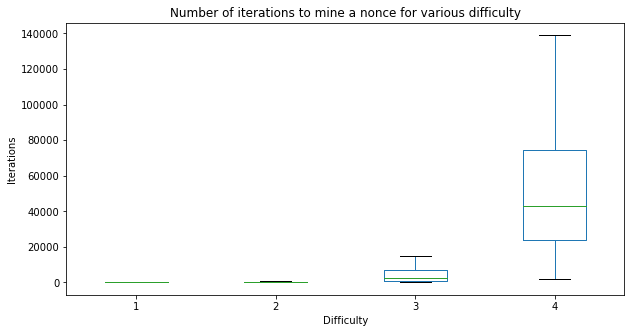

In [10]:
pl.figure(figsize=(10, 5))
ax = pl.subplot(111)
ax.set_title('Number of iterations to mine a nonce for various difficulty')
results.plot.box(showfliers=False, ax=ax)
ax.set_xlabel('Difficulty')
ax.set_ylabel('Iterations')

# A wallet <a name="wallet"></a>

In bitcoin a wallet is a private/public key pair. If you don't know what public/private key is, you should probably read about [RSA](https://en.wikipedia.org/wiki/RSA_%28cryptosystem%29).

The public key is used to receive transactions and the private key is used to spend money. By signing a transaction with our private key, anybody else can verify the signature using our public key.

Note that in bitcoin, the wallet is a little bit more complicated. A wallet is a set of multiple private/public key pairs, and an address is not directly the public key. This ensures better privacy and security, but for dumbcoin, we'll use a single key and use the public key as the address.

In [11]:
import Crypto
import Crypto.Random
from Crypto.Hash import SHA
from Crypto.PublicKey import RSA
from Crypto.Signature import PKCS1_v1_5


class Wallet(object):
    """
    A wallet is a private/public key pair
    """
    def __init__(self):
        random_gen = Crypto.Random.new().read
        self._private_key = RSA.generate(1024, random_gen)
        self._public_key = self._private_key.publickey()
        self._signer = PKCS1_v1_5.new(self._private_key)
        
    @property
    def address(self):
        """We take a shortcut and say address is public key"""
        return binascii.hexlify(self._public_key.exportKey(format='DER')).decode('ascii')
    
    def sign(self, message):
        """
        Sign a message with this wallet
        """
        h = SHA.new(message.encode('utf8'))
        return binascii.hexlify(self._signer.sign(h)).decode('ascii')
    
    
def verify_signature(wallet_address, message, signature):
    """
    Check that the provided `signature` corresponds to `message`
    signed by the wallet at `wallet_address`
    """
    pubkey = RSA.importKey(binascii.unhexlify(wallet_address))
    verifier = PKCS1_v1_5.new(pubkey)
    h = SHA.new(message.encode('utf8'))
    return verifier.verify(h, binascii.unhexlify(signature))


# Check that the wallet signing functionality works
w1 = Wallet()
signature = w1.sign('foobar')
assert verify_signature(w1.address, 'foobar', signature)
assert not verify_signature(w1.address, 'rogue message', signature)

# Doing transactions <a name="transactions"></a>

To exchange money between wallets, we'll use transactions. A transaction is composed of :
- A spender, who will sign the transaction and who's spending his money
- A number of inputs, which are other transactions' outputs. The recipient of all those should be the spender's wallet.
  Otherwise you could spend other people's money.
- A number of outputs, each of which specify an amount of money and a recipient

Transactions can also contain a "transaction fee" which is an incentive for the miner to include the transaction in a block (more on that later). The fee is just the difference between the total input amount and the total output amount.


Since all transactions need a parent, we also need a root in our hierarchy. This will be the *GenesisTransaction*.

In [12]:
class TransactionInput(object):
    """
    An input for a transaction. This points to an output of another transaction
    """
    def __init__(self, transaction, output_index):
        self.transaction = transaction
        self.output_index = output_index
        assert 0 <= self.output_index < len(transaction.outputs)
        
    def to_dict(self):
        d = {
            'transaction': self.transaction.hash(),
            'output_index': self.output_index
        }
        return d
    
    @property
    def parent_output(self):
        return self.transaction.outputs[self.output_index]
    

class TransactionOutput(object):
    """
    An output for a transaction. This specifies an amount and a recipient (wallet)
    """
    def __init__(self, recipient_address, amount):
        self.recipient = recipient_address
        self.amount = amount
        
    def to_dict(self):
        d = {
            'recipient_address': self.recipient,
            'amount': self.amount
        }
        return d

        
def compute_fee(inputs, outputs):
    """
    Compute the transaction fee by computing the difference between total input and total output
    """
    total_in = sum(i.transaction.outputs[i.output_index].amount for i in inputs)
    total_out = sum(o.amount for o in outputs)
    assert total_out <= total_in, "Invalid transaction with out(%f) > in(%f)" % (total_out, total_in)
    return total_in - total_out

    
class Transaction(object):
    def __init__(self, wallet, inputs, outputs):
        """
        Create a transaction spending money from the provided wallet
        """
        self.inputs = inputs
        self.outputs = outputs
        self.fee = compute_fee(inputs, outputs)
        self.signature = wallet.sign(json.dumps(self.to_dict(include_signature=False)))
        
    def to_dict(self, include_signature=True):
        d = {
            "inputs": list(map(TransactionInput.to_dict, self.inputs)),
            "outputs": list(map(TransactionOutput.to_dict, self.outputs)),
            "fee": self.fee
        }
        if include_signature:
            d["signature"] = self.signature
        return d
    
    def hash(self):
        return dumb_hash(json.dumps(self.to_dict()))
    
    
class GenesisTransaction(Transaction):
    """
    This is the first transaction which is a special transaction
    with no input and 25 bitcoins output
    """
    def __init__(self, recipient_address, amount=25):
        self.inputs = []
        self.outputs = [
            TransactionOutput(recipient_address, amount)
        ]
        self.fee = 0
        self.signature = 'genesis'
        
    def to_dict(self, include_signature=False):
        # TODO: Instead, should sign genesis transaction will well-known public key ?
        assert not include_signature, "Cannot include signature of genesis transaction"
        return super().to_dict(include_signature=False)

With the classes above, we can make transactions between alice and bob.

In [13]:
alice = Wallet()
bob = Wallet()

t1 = GenesisTransaction(alice.address)
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 2.0), TransactionOutput(alice.address, 22.0)]
)
assert np.abs(t2.fee - 1.0) < 1e-5

In bitcoin, you never store how much you have in your wallet. Instead, you go through the whole chain of transactions to compute how much you have. Let's write a function to do that

In [14]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

# This gives 25 coins to Alice
t1 = GenesisTransaction(alice.address)

# Of those 25, Alice will spend
# Alice -- 5 --> Bob
#       -- 15 --> Alice
#       -- 5 --> Walter
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)

# Walter -- 5 --> Bob
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

# Bob -- 8 --> Walter
#     -- 1 --> Bob
#        1 fee
t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

transactions = [t1, t2, t3, t4]


In [15]:
def compute_balance(wallet_address, transactions):
    """
    Given an address and a list of transactions, computes the wallet balance of the address
    """
    balance = 0
    for t in transactions:
        # Subtract all the money that the address sent out
        for txin in t.inputs:
            if txin.parent_output.recipient == wallet_address:
                balance -= txin.parent_output.amount
        # Add all the money received by the address
        for txout in t.outputs:
            if txout.recipient == wallet_address:
                balance += txout.amount
    return balance

print("Alice  has %.02f dumbcoins" % compute_balance(alice.address, transactions))
print("Bob    has %.02f dumbcoins" % compute_balance(bob.address, transactions))
print("Walter has %.02f dumbcoins" % compute_balance(walter.address, transactions))

Alice  has 15.00 dumbcoins
Bob    has 1.00 dumbcoins
Walter has 8.00 dumbcoins


We also want to be able to verify that a transaction is valid. This means :

- You can only spend your money. This means checking that all inputs are owned by the transaction's owner
- Ensure you don't spend more than you have. This is checked by the compute_fee function above

In [16]:
def verify_transaction(transaction):
    """
    Verify that the transaction is valid.
    We need to verify two things :
    - That all of the inputs of the transaction belong to the same wallet
    - That the transaction is signed by the owner of said wallet
    """
    tx_message = json.dumps(transaction.to_dict(include_signature=False))
    if isinstance(transaction, GenesisTransaction):
        # TODO: We should probably be more careful about validating genesis transactions
        return True
    
    # Verify input transactions
    for tx in transaction.inputs:
        if not verify_transaction(tx.transaction):
            logging.error("Invalid parent transaction")
            return False
    
    # Verify a single wallet owns all the inputs
    first_input_address = transaction.inputs[0].parent_output.recipient
    for txin in transaction.inputs[1:]:
        if txin.parent_output.recipient != first_input_address:
            logging.error(
                "Transaction inputs belong to multiple wallets (%s and %s)" %
                (txin.parent_output.recipient, first_input_address)
            )
            return False
    
    if not verify_signature(first_input_address, tx_message, transaction.signature):
        logging.error("Invalid transaction signature, trying to spend someone else's money ?")
        return False
    
    # Call compute_fee here to trigger an assert if output sum is great than input sum. Without this,
    # a miner could put such an invalid transaction.
    compute_fee(transaction.inputs, transaction.outputs)
    
    return True


t1 = GenesisTransaction(alice.address)
# This is an invalid transaction because bob is trying to spend alice's money
# (alice was the recipient of the input - t1)
t2 = Transaction(
    bob,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)
# This is valid, alice is spending her own money
t3 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)

In [17]:
assert verify_transaction(t1)

In [18]:
assert not verify_transaction(t2)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


In [19]:
assert verify_transaction(t3)

# Putting transactions in blocks <a name="block"></a>

Now that we have :

- A way to define a wallet (as a private/public key pair)
- A way to create transactions between wallets
- A way to verify transactions (by checking the signature matches

What remains is to group transactions into blocks and have miners mine blocks. Mining a block consists of two parts :
- Verifying the transactions in the block
- Finding a nonce such that the block's hash starts with a number of 0

Also, mining generates money by the convention that the first transaction in a block is a GenesisTransaction that gives 25 coins to whatever address the miner chose.
In the same way, the miner can add transactions to redirect the fees from the transactions in the block to whatever address it chooses.

In [20]:
BLOCK_INCENTIVE = 25 # The number of coins miners get for mining a block
DIFFICULTY = 2


def compute_total_fee(transactions):
    """Return the total fee for the set of transactions"""
    return sum(t.fee for t in transactions)


class Block(object):
    def __init__(self, transactions, ancestor, miner_address, skip_verif=False):
        """
        Args:
            transactions: The list of transactions to include in the block
            ancestor: The previous block
            miner_address: The address of the miner's wallet. This is where the block
                           incentive and the transactions fees will be deposited
        """
        reward = compute_total_fee(transactions) + BLOCK_INCENTIVE
        self.transactions = [GenesisTransaction(miner_address, amount=reward)] + transactions
        self.ancestor = ancestor
        
        if not skip_verif:
            assert all(map(verify_transaction, transactions))
        
        json_block = json.dumps(self.to_dict(include_hash=False))
        self.nonce, _ = mine(json_block, DIFFICULTY)
        self.hash = dumb_hash(json_block + self.nonce)
        
    def fee(self):
        """Return transaction fee for this block"""
        return compute_total_fee(self.transactions)
    
    def to_dict(self, include_hash=True):
        d = {
            "transactions": list(map(Transaction.to_dict, self.transactions)),
            "previous_block": self.ancestor.hash,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d
    
    
class GenesisBlock(Block):
    """
    The genesis block is the first block in the chain.
    It is the only block with no ancestor
    """
    def __init__(self, miner_address):
        super(GenesisBlock, self).__init__(transactions=[], ancestor=None, miner_address=miner_address)

    def to_dict(self, include_hash=True):
        d = {
            "transactions": [],
            "genesis_block": True,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d

Similarly to how we verify transactions, we also need a way to verify blocks :

In [21]:
def verify_block(block, genesis_block, used_outputs=None):
    """
    Verifies that a block is valid :
    - Verifies the hash starts with the required amount of ones
    - Verifies that the same transaction output isn't used twice
    - Verifies all transactions are valid
    - Verifies the first transaction in the block is a genesis transaction with BLOCK_INCENTIVE + total_fee
    
    Args:
        block: The block to validate
        genesis_block: The genesis block (this needs to be shared by everybody. E.g. hardcoded somewhere)
        used_outputs: list of outputs used in transactions for all blocks above this one
    """
    if used_outputs is None:
        used_outputs = set()
    
    # Verify hash
    prefix = '1' * DIFFICULTY
    if not block.hash.startswith(prefix):
        logging.error("Block hash (%s) doesn't start with prefix %s" % (block.hash, prefix))
        return False
    if not all(map(verify_transaction, block.transactions)):
        return False
    
    # Verify that transactions in this block don't use already spent outputs
    #
    # Note that we could move this in verify_transaction, but this would require some passing the used_outputs
    # around more. So we do it here for simplicity
    for transaction in block.transactions:
        for i in transaction.inputs:
            if i.parent_output in used_outputs:
                logging.error("Transaction uses an already spent output : %s" % json.dumps(i.parent_output.to_dict()))
                return False
            used_outputs.add(i.parent_output)
    
    # Verify ancestors up to the genesis block
    if not (block.hash == genesis_block.hash):
        if not verify_block(block.ancestor, genesis_block, used_outputs):
            logging.error("Failed to validate ancestor block")
            return False
    
    # Verify the first transaction is the miner's reward
    tx0 = block.transactions[0]
    if not isinstance(tx0, GenesisTransaction):
        logging.error("Transaction 0 is not a GenesisTransaction")
        return False
    if not len(tx0.outputs) == 1:
        logging.error("Transactions 0 doesn't have exactly 1 output")
        return False
    reward = compute_total_fee(block.transactions[1:]) + BLOCK_INCENTIVE
    if not tx0.outputs[0].amount == reward:
        logging.error("Invalid amount in transaction 0 : %d, expected %d" % (tx0.outputs[0].amount, reward))
        return False
    
    # Only the first transaction shall be a genesis
    for i, tx in enumerate(block.transactions):
        if i == 0:
            if not isinstance(tx, GenesisTransaction):
                logging.error("Non-genesis transaction at index 0")
                return False  
        elif isinstance(tx, GenesisTransaction):
            logging.error("GenesisTransaction (hash=%s) at index %d != 0", tx.hash(), i)
            return False
    return True

In [22]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

genesis_block = GenesisBlock(miner_address=alice.address)
print("genesis_block : " + genesis_block.hash + " with fee=" + str(genesis_block.fee()))

t1 = genesis_block.transactions[0]
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

block1 = Block([t2], ancestor=genesis_block, miner_address=walter.address)
print("block1        : " + block1.hash + " with fee=" + str(block1.fee()))

block2 = Block([t3, t4], ancestor=block1, miner_address=walter.address)
print("block2        : " + block2.hash + " with fee=" + str(block2.fee()))

genesis_block : 1162dce8ffec3acf13ce61109f121922eee8cceeea4784aa9d90dc6ec0e0fa92 with fee=0
block1        : 11af277c02c22a7e3c3a73102282ca5a0e01869b1d852527b6a842f0786ee8e3 with fee=0.0
block2        : 119e461d393b793478c7c7cb9fa6feb54fca35865a398d017e541027a78a2e9a with fee=1.0


In [23]:
verify_block(block1, genesis_block)
verify_block(block2, genesis_block)

True

In [24]:
def collect_transactions(block, genesis_block):
    """Recursively collect transactions in `block` and all of its ancestors"""
    # Important : COPY block.transactions
    transactions = [] + block.transactions
    if block.hash != genesis_block.hash:
        transactions += collect_transactions(block.ancestor, genesis_block)
    return transactions

transactions = collect_transactions(block2, genesis_block)

# Alice mined 25 (from the genesis block) and gave 5 to bob and 5 to walter
print("Alice  has %.02f dumbcoins" % compute_balance(alice.address, transactions))
# Bob received 5 from alice and 5 from walter, but then back 8 to walter with a transaction fee of 1
print("Bob    has %.02f dumbcoins" % compute_balance(bob.address, transactions))
# Walter mined 2 blocks (2 * 25), received 8 from bob and go a transaction fee of 1 on block2
print("Walter has %.02f dumbcoins" % compute_balance(walter.address, transactions))

Alice  has 15.00 dumbcoins
Bob    has 1.00 dumbcoins
Walter has 59.00 dumbcoins


# Some attacks <a name="attacks"></a>

Now, if our miner (walter) tries to spend bob's money, his block won't verify :

In [25]:
tx = Transaction(
    walter,
    [TransactionInput(t4, 1)],
    [TransactionOutput(walter.address, 1.0)],
)

# Note that we have to use skip_verif=True to not trigger the assert in Block's constructor
block = Block([tx], ancestor=block2, miner_address=walter.address, skip_verif=True)
assert not verify_block(block, genesis_block)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


Another possible attack would be for the miner to modify a transaction it include in its block. Again, this won't work

In [26]:
# This is a transaction signed by bob
tx = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)
# And modified by the miner
tx.outputs[0].amount += 4
block = Block([t3, tx], ancestor=block1, miner_address=walter.address, skip_verif=True)
assert not verify_block(block, genesis_block)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


A signed transaction could also be duplicated, increasing the total coins in circulation.

In [27]:
block = Block([t3, t3, t4], ancestor=block1, miner_address=bob.address, skip_verif=True)
assert not verify_block(block, genesis_block)

ERROR:root:Transaction uses an already spent output : {"recipient_address": "30819f300d06092a864886f70d010101050003818d0030818902818100aec88246cc7e63c404c083b34ce153bdcf25749ec8d8764df14c0940ec795ce7522c9923e7aad577f60d346939e6c6aff45c432c6644cef675efb336fc24bdbb966d1448521537390b502c5677251e40c4a0d7b8ec9be732c21b9fe7bac7dc0f8551677645a6b89a8a39ac581fc2d440867f46994d1a52d1ddc1a22f67740f3f0203010001", "amount": 5.0}


# Majority attack <a name="majority_attack"></a>

The tools built up so-far ensure that the ledger is self-consistent: money is spent by addresses which own that money. However, a flaw remains: given that there isn't a central copy of the ledger, which is to be trusted ? The rule is that you trust the **longest chain**. Let's see what are the limits of this rule.

In [28]:
# Let's start again with the same example transactions and blocks as above
alice = Wallet()
bob = Wallet()
walter = Wallet()

genesis_block = GenesisBlock(miner_address=alice.address)

t1 = genesis_block.transactions[0]
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

block1 = Block([t2], ancestor=genesis_block, miner_address=walter.address)
block2 = Block([t3, t4], ancestor=block1, miner_address=walter.address)

So with t4 above, bob sent 8 coins to walter. Let's assume walter is a merchant and he sold bob a nice car in exchange of those 8 coins. Bob now has a car and walter has 8 coins.

Bob is feeling a bit poor and decides he'd rather not have spent those 8 coins in `block2`. He re-writes history a bit, putting a transaction to himself and mines his own block.

In [29]:
t4_malicious = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(bob.address, 8.0), TransactionOutput(bob.address, 1.0)]
)
block2_malicious = Block([t3, t4_malicious], ancestor=block1, miner_address=bob.address)
print(verify_block(block2_malicious, genesis_block))

True


The `block2_malicious` isn't yet accepted by the network as it hasn't surpassed the longest ledger (`block2`).
More transactions are made, to be mined in the next block. Bob happens to mine the new block with this last transaction.

In [30]:
t6 = Transaction(
    alice,
    [TransactionInput(t2, 1)],
    [TransactionOutput(walter.address, 5.0), TransactionOutput(alice.address, 10.0)]
)

block3_malicious = Block([t6], ancestor=block2_malicious, miner_address=bob.address)

Now the rule in Bitcoin is that everybody trust the longest chain. So let's check which one is the longest

In [31]:
def chain_length(block):
    if block.ancestor is None:
        return 1
    else:
        return 1 + chain_length(block.ancestor)

print("Chain length for block2           : %d" % chain_length(block2))
print("Chain length for block3_malicious : %d " % chain_length(block3_malicious))

Chain length for block2           : 3
Chain length for block3_malicious : 4 


The accepted ledger is now `block3_malicious`, as it is the longest ledger. Bob has successfully re-written the ledger. On the other hand, he still has the car that he got from walter in exchange of the 8 coins, it's just that the transaction where walter received 8 coins isn't considered the truth so walter won't have those 8 coins.

This is a 51% or [Majority attack](https://en.bitcoin.it/wiki/Majority_attack). 

In practice, however, Walter had a head start on computing `block3 = Block([t6], ancestor=block2, miner_address=walter.address)`, and that `block3` would be accepted by the network. Bob would either have to be very lucky and find the correct nonce very quickly, or would have to keep mining blocks slightly faster than Walter to eventually create a longer ledger which incorporates his modified history.

There are three interesting things we can learn from this example :
- Even with a majority of mining power, an attacker can only change one of his transaction. He can't create money
  out of thin air (this would require invalid blocks) or spend other people's money (he wouldn't be able to sign
  the transaction).
- An expensive proof of work is required to make sure it's costly to create valid blocks. If the proof of work was
  trivial, the network would be spammed by concurrent chains and it would never reach a consensus.
- The "trust the longest chain" rule is the reason why you wait for a number of confirmations before considering
  a transaction done. The number of confirmation of a transaction is how many blocks behind the last one a transaction
  is. The more confirmations you wait for, the costlier it become for an attacker to change his transaction.

# Main differences with Bitcoin <a name="differences"></a>

As explained above, the goal is not to have a conformant Bitcoin implementation and therefore many things are not implemented. The most important are :

- This uses the wallet public key as its address. Bitcoin uses [more complicated addresses](https://en.bitcoin.it/wiki/Technical_background_of_version_1_Bitcoin_addresses)
- Bitcoin uses ECDSA for signature, this uses RSA.
- Bitcoin uses two rounds of SHA256, this uses one
- Bitcoin transactions use a [scripting language](https://en.bitcoin.it/wiki/Script). Here we just have
  simple transactions with one amount per output
- Bitcoin requires a way to broadcast blocks to all the nodes. The whole communication part is left out from this    notebook.
  See the [Client Node Discovery](https://en.bitcoin.it/wiki/Satoshi_Client_Node_Discovery) and [Protocol documentation](https://en.bitcoin.it/wiki/Protocol_documentation) pages on the bitcoin wiki
- Bitcoin uses a [Merkle tree](https://en.wikipedia.org/wiki/Merkle_tree) to save disk space by pruning spent   
  transactions.
  
Thanks to HN users *westurner*, *vinn124*, *ivan_ah* and *magnat* for helping me figure out the main differences.

## Security issues

In addition to the differences above, there are a number of security issues with this implementation (pointed out by HN user *magnat*) :
- Use of floating point arithmetic can lead to many problems (e.g. loss of precisions).
- The JSON serialization as implemented here is not reproducible across platforms. For example, two serialization of
  the same transaction on two different platforms could produce two different JSON (line endings, keys ordering,   spaces).
- The mine method implemented here can loop forever due to integer overflow.